# HW 1
在这一章，我们实现了一个用于100个参数的凸函数的 Newton Descent算法，并且满足 Armijo 条件。

## 1. Rosenbrock 函数
Rosenbrock函数，又称为“香蕉函数”，是优化算法中常用的测试函数，主要用于测试优化算法在非凸、非线性目标函数下的表现。其定义如下：

$$
f(x, y) = (a - x)^2 + b(y - x^2)^2
$$

其中，常用参数为 $a=1$ 和 $b=100$。Rosenbrock函数具有一个全局最小值，位于 $(x, y) = (a, a^2)$，此时 $f(x, y) = 0$。由于其狭长弯曲的谷底结构，Rosenbrock函数常用于测试优化算法在复杂地形下的表现。

函数特点：
- 全局极小值：在 ((x, y) = (a, a^2)) 处取得最小值0（常用参数下为 (1, 1)）。
- 形状像香蕉：其等高线呈现弯曲的“谷地”形状，因此也叫banana function。
- 优化难度：虽然极小值处于一个狭长的抛物线形谷底，但谷底很平坦，梯度下降等优化算法容易陷入困境，考验算法的收敛能力和鲁棒性。

In [8]:
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("ForwardDiff")
import Pkg; Pkg.add("LinearAlgebra")


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [37e2e46d] + LinearAlgebra
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


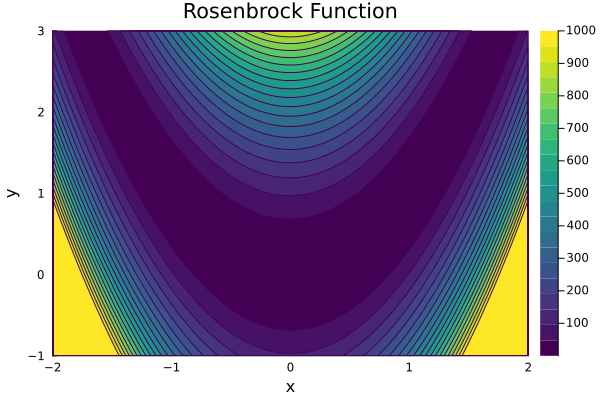

In [5]:
using Plots

# 定义Rosenbrock函数
rosenbrock(x, y; a=1, b=100) = (a - x)^2 + b * (y - x^2)^2

# 生成网格数据
x = range(-2, 2, length=400)
y = range(-1, 3, length=400)
z = [rosenbrock(xi, yi) for yi in y, xi in x]

# 绘制等高线图（对数色标）
contourf(x, y, z; c=:viridis, colorbar=true, clims=(1e-4, 1e3), levels=20, fill=true, yflip=false, color=:viridis, colorbar_title="",
         xlab="x", ylab="y", title="Rosenbrock Function", zscale=:log10)

## 牛顿法中的搜索方向推导

在牛顿法中，我们使用二阶泰勒展开来近似目标函数：

$$f(x + p) \approx f(x) + \nabla f(x)^T p + \frac{1}{2} p^T H p$$

为了找到最小值，对搜索方向 $p$ 求导并令其等于零：

$$\frac{d}{dp}[f(x) + \nabla f(x)^T p + \frac{1}{2} p^T H p] = \nabla f(x) + H p = 0$$

解得牛顿搜索方向：
$$H p = -\nabla f(x) \quad \Rightarrow \quad p = -H^{-1} \nabla f(x)$$

在代码中：
- `g` 是梯度 $\nabla f(x)$
- `H` 是Hessian矩阵
- `H \ g` 计算 $H^{-1}g$（求解线性方程组，比直接求逆更稳定）
- `p = -H \ g` 就是 $p = -H^{-1}g$，即标准的牛顿搜索方向

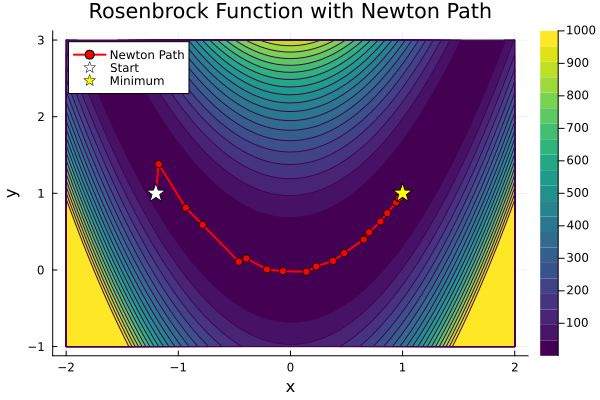

In [10]:
using LinearAlgebra, ForwardDiff

# 已定义 rosenbrock(x, y; a=1, b=100)
rosenbrock_vec(x; a=1, b=100) = (a - x[1])^2 + b * (x[2] - x[1]^2)^2

# 梯度
function rosenbrock_grad(x; a=1, b=100)
    ForwardDiff.gradient(y -> rosenbrock_vec(y; a=a, b=b), x)
end

# Hessian
function rosenbrock_hess(x; a=1, b=100)
    ForwardDiff.hessian(y -> rosenbrock_vec(y; a=a, b=b), x)
end

# Armijo 条件
function armijo(f, x, p, grad; α=1.0, β=0.5, σ=1e-4)
    fx = f(x)
    while f(x + α * p) > fx + σ * α * dot(grad, p)
        α *= β
    end
    return α
end

# 带 Armijo 的阻尼牛顿法
function damped_newton_armijo(f, grad_f, hess_f, x0; tol=1e-8, maxiter=1000)
    x = copy(x0)
    for iter in 1:maxiter
        g = grad_f(x)
        H = hess_f(x)
        if norm(g) < tol
            break
        end
        # 防止Hessian不可逆
        p = -H \ g
        α = armijo(f, x, p, g)
        x += α * p
    end
    return x
end

# 初始点
x0 = [-1.2; 1.0]
# 记录路径
path = [x0]
function damped_newton_armijo_path(f, grad_f, hess_f, x0; tol=1e-8, maxiter=1000)
    x = copy(x0)
    path = [copy(x)]
    for iter in 1:maxiter
        g = grad_f(x)
        H = hess_f(x)
        if norm(g) < tol
            break
        end
        p = -H \ g
        α = armijo(f, x, p, g)
        x += α * p
        push!(path, copy(x))
    end
    return x, path
end

_, path = damped_newton_armijo_path(rosenbrock_vec, rosenbrock_grad, rosenbrock_hess, x0)
path_x = [p[1] for p in path]
path_y = [p[2] for p in path]

contourf(x, y, z; c=:viridis, colorbar=true, clims=(1e-4, 1e3), levels=20, fill=true, yflip=false, color=:viridis, colorbar_title="",
         xlab="x", ylab="y", title="Rosenbrock Function with Newton Path", zscale=:log10)
plot!(path_x, path_y, lw=2, marker=:circle, color=:red, label="Newton Path")
scatter!([x0[1]], [x0[2]], color=:white, marker=:star5, ms=10, label="Start")
scatter!([1.0], [1.0], color=:yellow, marker=:star5, ms=10, label="Minimum")